# Comparing Accuracy of BERT Using Pre and Post Tuning

## 1. Data Preperation

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


### 1.1 Load and Preprocess Data

In [4]:
import pandas as pd
import os
import re
import string

# Load the dataset
df = pd.read_csv("HateSpeechDatasetBalanced.csv")

# Ensure the dataset has 'text' and 'label' columns
print(df.head())

# Preprocess text
def preprocess_text(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove mentions and hashtags
    text = re.sub(r'@\w+|#\w+', '', text)
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Lowercase
    text = text.lower()
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['clean_text'] = df['Content'].apply(preprocess_text)


                                             Content  Label
0  denial of normal the con be asked to comment o...    1.0
1  just by being able to tweet this insufferable ...    1.0
2  that is retarded you too cute to be single tha...    1.0
3  thought of a real badass mongol style declarat...    1.0
4                                afro american basho    1.0


### 1.2 Split the Data

In [5]:
from sklearn.model_selection import train_test_split

# Split into training and temp (which will be split into validation and test)
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df['clean_text'].tolist(), df['Label'].tolist(), test_size=0.3, random_state=42
)

# Split temp into validation and test sets
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, random_state=42
)

print(f"Training samples: {len(train_texts)}")
print(f"Validation samples: {len(val_texts)}")
print(f"Testing samples: {len(test_texts)}")


Training samples: 243268
Validation samples: 52129
Testing samples: 52129


## 2. Baseline Model Evaluation

### 2.1 Load the Pretrained Model

In [6]:
from transformers import BertTokenizer, TFBertForSequenceClassification
import tensorflow as tf

# Load the tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 2.2 Prepare the Test

In [7]:
def tokenize(texts):
    return tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors='tf'
    )

# Tokenize the test texts
test_encodings = tokenize(test_texts)

# Create TensorFlow dataset for testing
test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    test_labels
)).batch(16)

### 2.3 Evaluate Model Before Fine Tuning

In [10]:
# Compile the model with the same settings we'll use during fine-tuning
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.metrics.SparseCategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

# Evaluate the model on the test set
baseline_loss, baseline_accuracy = model.evaluate(test_dataset)
print(f"Baseline Test Accuracy: {baseline_accuracy * 100:.2f}%")


3259/3259 [==============================] - 482s 146ms/step - loss: nan - accuracy: 0.3196
Baseline Test Accuracy: 31.96%


## 3. Model Fine Tuning

### 3.1 Prepare the Training and Validation Data

In [11]:
# Tokenize the training and validation texts
train_encodings = tokenize(train_texts)
val_encodings = tokenize(val_texts)

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
)).shuffle(1000).batch(16)

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
)).batch(16)


### 3.2 Fine Tune the Model

In [12]:
# Re-initialize the model to ensure we're starting fresh
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Create Optimizer
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=2e-5)

# Compile the model
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

# Define callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
]

# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=3,
    callbacks=callbacks
)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
15205/15205 [==============================] - 6705s 440ms/step - loss: 0.2754 - accuracy: 0.7804 - val_loss: 0.2520 - val_accuracy: 0.8907
Epoch 2/3
15205/15205 [==============================] - 6647s 437ms/step - loss: 0.2021 - accuracy: 0.9132 - val_loss: 0.2900 - val_accuracy: 0.8949
Epoch 3/3
15205/15205 [==============================] - 6638s 437ms/step - loss: 0.1426 - accuracy: 0.9403 - val_loss: 0.3204 - val_accuracy: 0.8919


## 4. Post Fine-Tuning Evaluation

### 4.1 Evaluate the Model After Fine Tuning

In [13]:
# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Post-Fine-Tuning Test Accuracy: {test_accuracy * 100:.2f}%")

3259/3259 [==============================] - 473s 145ms/step - loss: nan - accuracy: 0.8934
Post-Fine-Tuning Test Accuracy: 89.34%


## 5. Result Visualization

### 5.1 Collect Accuracies

In [14]:
# Baseline accuracy
baseline_acc = baseline_accuracy * 100

# Training and validation accuracies during fine-tuning
train_acc = [acc * 100 for acc in history.history['accuracy']]
val_acc = [acc * 100 for acc in history.history['val_accuracy']]

# Post-fine-tuning test accuracy
post_finetune_acc = test_accuracy * 100

# Epochs
epochs = range(1, len(train_acc) + 1)

### 5.2 Plot the Accuracies

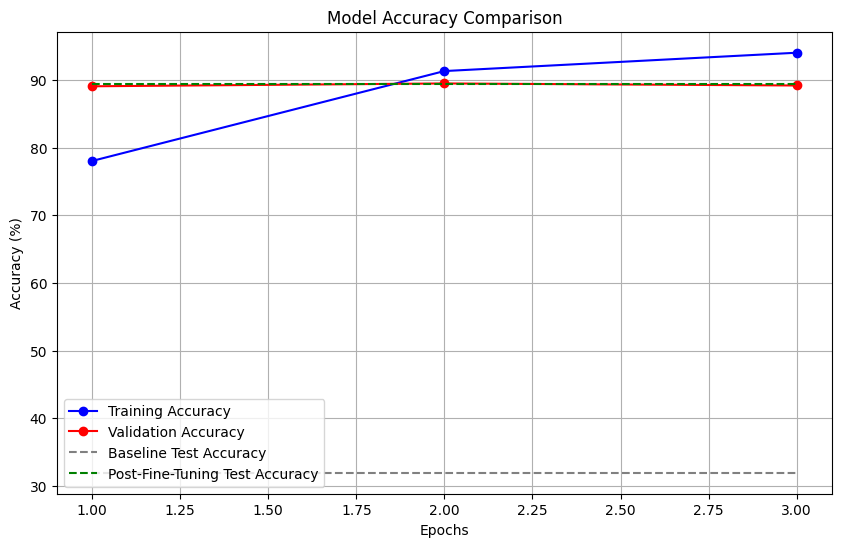

In [15]:
import matplotlib.pyplot as plt

# Plot training and validation accuracies
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_acc, 'b-o', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-o', label='Validation Accuracy')

# Plot baseline and post-fine-tuning test accuracies
plt.hlines(y=baseline_acc, xmin=1, xmax=len(epochs), colors='gray', linestyles='dashed', label='Baseline Test Accuracy')
plt.hlines(y=post_finetune_acc, xmin=1, xmax=len(epochs), colors='green', linestyles='dashed', label='Post-Fine-Tuning Test Accuracy')

plt.title('Model Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[]
